In [20]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

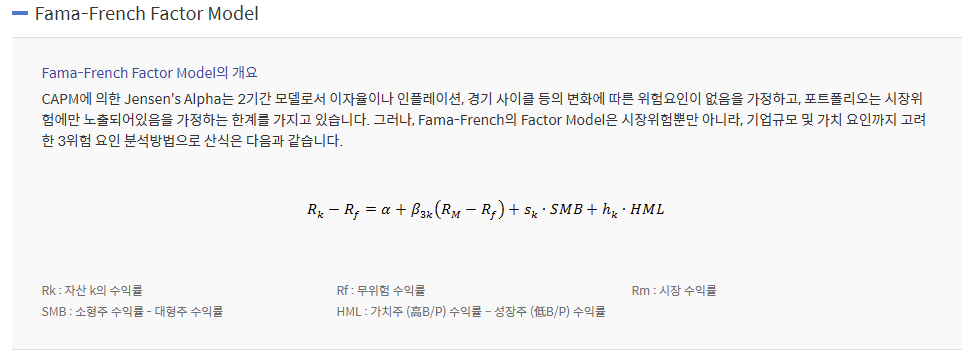

In [103]:
import pandas as pd
import yfinance as yf
# import statsmodels as sm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant

In [104]:
file_path = 'FF3_MODEL_KOREA_240930.csv'
factor_3_df = pd.read_csv(file_path)

# Convert the 'DATE' column to datetime format (assuming YYYYMM format)
factor_3_df['DATE'] = pd.to_datetime(factor_3_df['DATE'], format='%Y%m')

factor_3_df.set_index('DATE', inplace=True)
factor_3_df.index = factor_3_df.index.to_period('M')

factor_3_df.head()

,Rm,Rf,SMB,HML,MOM
DATE,,,,,
2005-01,6.7948,3.48,18.66745,-7.98909,-4.71073
2005-02,8.6761,3.55,3.42790,10.48102,10.50354
2005-03,-4.8578,3.54,-3.56190,2.85851,-2.89546
2005-04,-5.7420,3.48,0.79005,5.11877,2.39521
2005-05,6.8575,3.52,4.34058,-6.98654,-1.82599


In [105]:
RISKY_ASSET = "000660.KS"
START_DATE = "2016-12-30"
END_DATE = "2024-08-31"

In [106]:
factor_3_df['Mkt'] = factor_3_df['Rm'] -factor_3_df['Rf']
factor_3_df = factor_3_df[START_DATE:END_DATE]
factor_3_df = factor_3_df.div(100)
factor_3_df 

,Rm,Rf,SMB,HML,MOM,Mkt
DATE,,,,,,
2016-12,0.029305,0.0152,0.034292,0.005262,-0.004016,0.014105
2017-01,0.019011,0.0149,-0.016883,0.024101,0.033746,0.004111
2017-02,0.007147,0.0149,-0.037517,0.008094,-0.048908,-0.007753
2017-03,0.033237,0.0145,-0.005732,0.006886,0.022595,0.018737
2017-04,0.021622,0.0141,-0.021836,-0.017135,-0.012191,0.007522
...,...,...,...,...,...,...
2024-04,-0.026101,0.0357,0.009294,0.044314,0.026577,-0.061801
2024-05,-0.019993,0.0361,0.029306,0.041985,0.027153,-0.056093
2024-06,0.059206,0.0360,-0.051903,0.050288,0.078813,0.023206


In [107]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

In [108]:
y = asset_df["Adj Close"].resample("M") \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.to_period("m")
y.name = "rtn"
y

Date
2017-02   -0.130354
2017-03    0.081370
2017-04    0.069307
2017-05    0.055555
2017-06    0.182456
             ...   
2024-04   -0.048087
2024-05    0.086108
2024-06    0.251584
2024-07   -0.177167
2024-08   -0.107400
Freq: M, Name: rtn, Length: 91, dtype: float64

In [109]:
factor_3_df = factor_3_df.join(y)
factor_3_df = factor_3_df.drop(factor_3_df.index[0])
factor_3_df["excess_rtn"] = (
    factor_3_df["rtn"] - factor_3_df["Rf"]
)
factor_3_df.head()

,Rm,Rf,SMB,HML,MOM,Mkt,rtn,excess_rtn
DATE,,,,,,,,
2017-01,0.019011,0.0149,-0.016883,0.024101,0.033746,0.004111,NaN,NaN
2017-02,0.007147,0.0149,-0.037517,0.008094,-0.048908,-0.007753,-0.130354,-0.145254
2017-03,0.033237,0.0145,-0.005732,0.006886,0.022595,0.018737,0.081370,0.066870
2017-04,0.021622,0.0141,-0.021836,-0.017135,-0.012191,0.007522,0.069307,0.055207
2017-05,0.058505,0.0138,-0.037501,0.007859,-0.024560,0.044705,0.055555,0.041755


In [110]:
# define and fit the regression model 
ff_model = smf.ols(formula="excess_rtn ~ Mkt + SMB + HML", 
                   data=factor_3_df).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     17.69
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           4.75e-09
Time:                        13:27:00   Log-Likelihood:                 104.27
No. Observations:                  91   AIC:                            -200.5
Df Residuals:                      87   BIC:                            -190.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0144      0.009      1.689      0.0

In [111]:
# define and fit the regression model 
ff_model = smf.ols(formula="excess_rtn ~ Mkt + SMB + HML + MOM", 
                   data=factor_3_df).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     13.77
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           1.02e-08
Time:                        13:27:01   Log-Likelihood:                 105.13
No. Observations:                  91   AIC:                            -200.3
Df Residuals:                      86   BIC:                            -187.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0145      0.009      1.698      0.0